In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import torch.nn as nn
import dtnnlib as dtnn
# import resnet_cifar

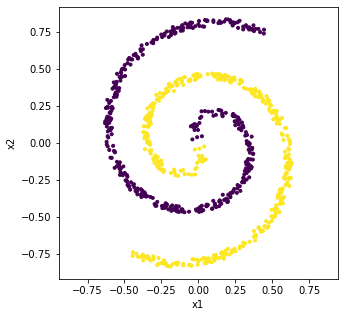

In [80]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 480 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

x, y = twospirals(400)
x, y = x/10, y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x1, x2, c=y, marker='.')
# plt.savefig("./clf_toy_data.pdf")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

In [81]:
device = torch.device("cuda:0")

In [82]:
criterion = nn.BCELoss()

In [83]:
xx, yy = xx.to(device), yy.to(device)

## Any function as metric

In [84]:
class FunctionDT(nn.Module):
    
    def __init__(self, input_dim, num_centers, func, inv_temp=0.):
        '''
        func [input_dim -> 1]
        '''
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        self.func = func
        
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.centers = torch.randn(num_centers, input_dim)/3.
        self.centers = nn.Parameter(self.centers)
    
    def forward(self, x):
        z = x.unsqueeze(1) - self.centers.unsqueeze(0)
        dists = self.func(z).squeeze(-1)
        dists = dists*torch.exp(self.inv_temp)

#         dists = dists*torch.exp(self.inv_temp)
        dists = dists-dists.mean(dim=-1, keepdim=True)
        dists = dists/torch.sqrt(dists.var(dim=-1, keepdim=True) + 1e-6)
        return -dists

In [85]:
from classes import DistanceRegressor, ConvexNN
from nflib.flows import SequentialFlow, ActNorm
import nflib.res_flow as irf

In [122]:
def get_models_func(h = 5, func_h=20, device='cpu'):
    layer1 = {
        "convex":ConvexNN([2, func_h, 1]),
        "invex":nn.Sequential(
                    ActNorm(2),
                    irf.ResidualFlow(2, [func_h], activation=irf.LeakyReLU),
                    ActNorm(2),
                    DistanceRegressor(2),
                    ),
        "ordinary":nn.Sequential(
                    ActNorm(2),
                    irf.ResidualFlow(2, [func_h], activation=irf.LeakyReLU),
                    ActNorm(2),
                    DistanceRegressor(2),
                    ),
    }
    irf.remove_spectral_norm_model(layer1["ordinary"])

    net_dict = {}
    for key in layer1:
        net = nn.Sequential(
#             FunctionDT(2, h, layer1[key]),
            dtnn.DistanceTransformBase(2, h),
            nn.BatchNorm1d(h),
            nn.ELU(),
            nn.Linear(h, 1),
            nn.Sigmoid(),
            )
        net_dict[key] = net.to(device)
    return net_dict

In [123]:
exp_mse_vals = {}
h = 3
net_dict = {
            **get_models_func(h, device=device),
            }
mse_dict = {}

Yes Linear(in_features=2, out_features=20, bias=True)
Success
Yes Linear(in_features=20, out_features=2, bias=True)
Success


In [124]:
# for key in net_dict:
key = 'convex'
print("_________________________")
print(f"Experimenting for {key} ; h:{h}")
net = net_dict[key]
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
for epoch in range(10000):
    break
    yout = net(xx)
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker= '.')
        plt.show()

#     mse_dict[key] = float(accuracy)
# exp_mse_vals[str(h)] = mse_dict

_________________________
Experimenting for convex ; h:3


In [131]:
dists = net[0](xx).data
dists.shape

torch.Size([800, 3])

In [142]:
XX = torch.autograd.Variable(torch.randn_like(xx)*0.0, requires_grad=True)

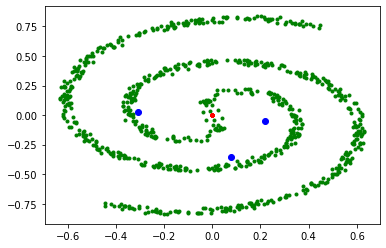

In [143]:
%matplotlib inline
fig = plt.figure()
plt.scatter(xx[:,0].cpu(), xx[:,1].cpu(), c='g', marker='.')
plt.scatter(XX.data[:,0].cpu(), XX.data[:,1].cpu(), c='r', marker='.')
plt.scatter(net[0].centers.data[:,0].cpu(), net[0].centers.data[:,1].cpu(), c='b', marker='o')

In [147]:
xoptim = torch.optim.Adam([XX], lr=0.01)
criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss()

In [148]:
def seq_criterion(yout, dists, num_cents):
    ## solve for each centroid sequentially
    error = ((dists[:, :num_cents]-yout[:, :num_cents])**2).mean()
    return error

Step: 0, error: 0.005306


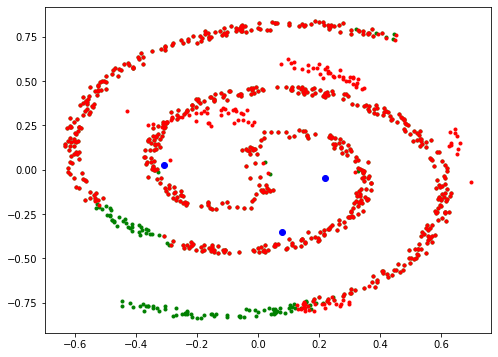

Step: 1000, error: 0.003444


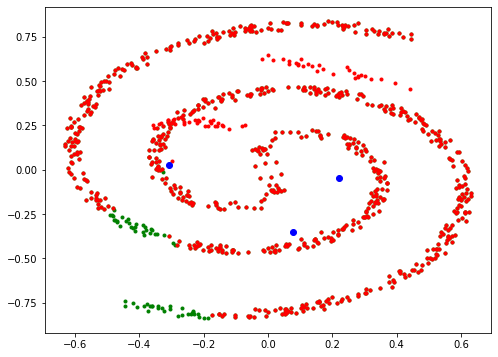

Step: 2000, error: 0.003444


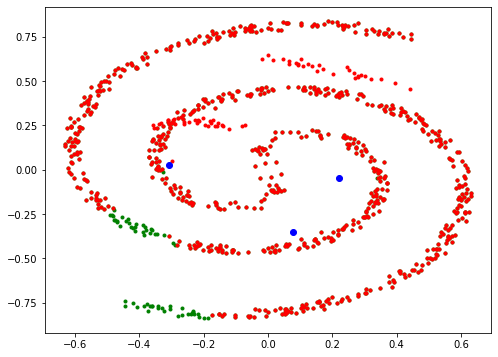

Step: 3000, error: 0.003444


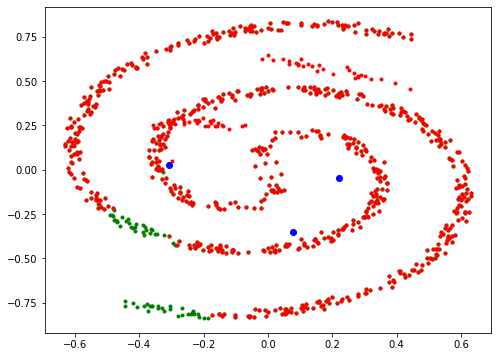

Step: 4000, error: 0.003444


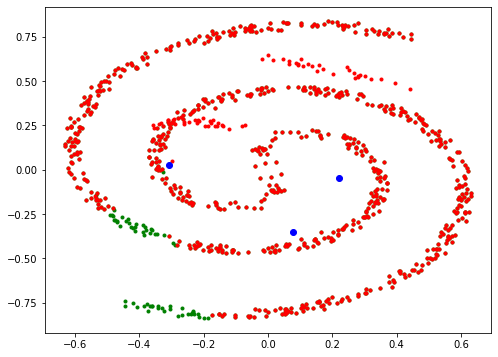

Step: 5000, error: 0.003444


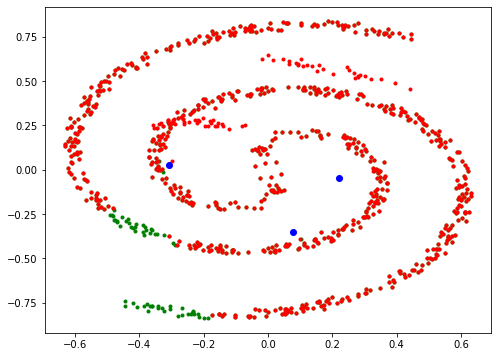

Step: 6000, error: 0.003444


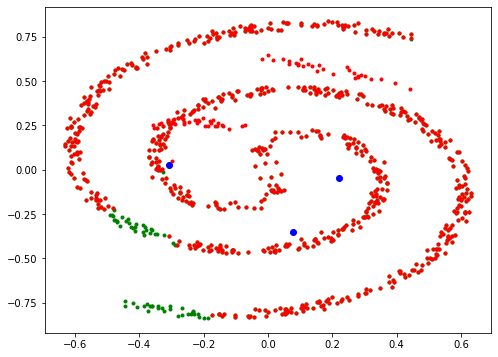

Step: 7000, error: 0.003444


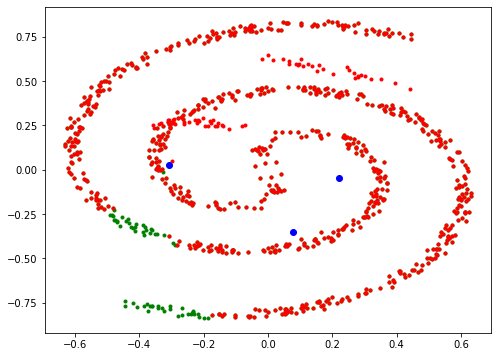

Step: 8000, error: 0.003444


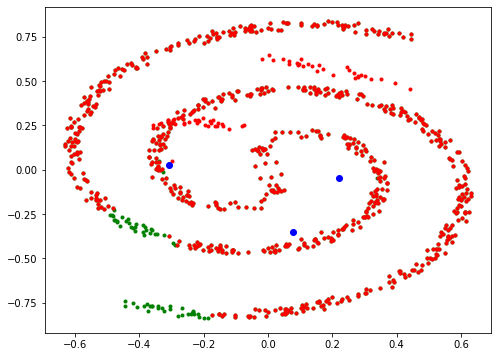

Step: 9000, error: 0.003444


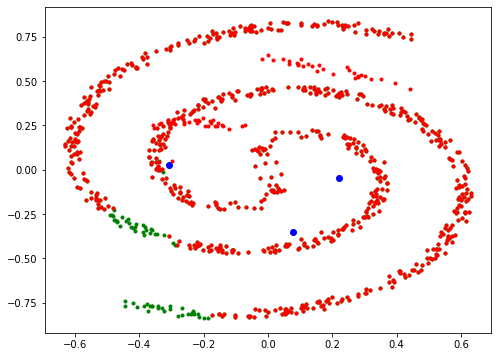

Step: 10000, error: 0.003444


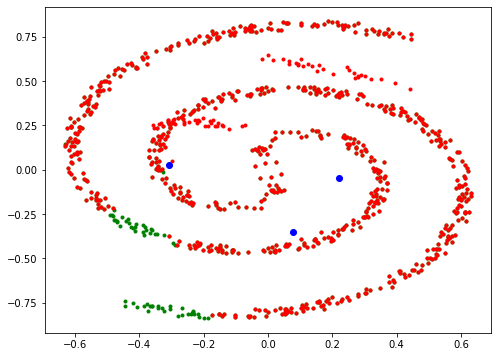

Step: 11000, error: 0.003444


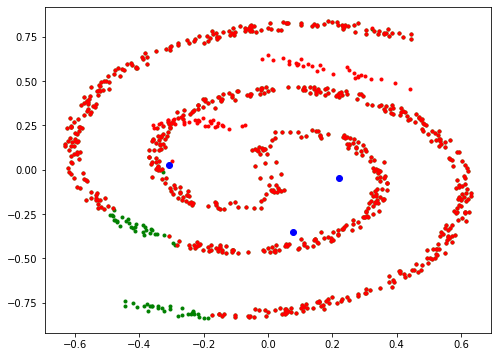

Step: 12000, error: 0.003444


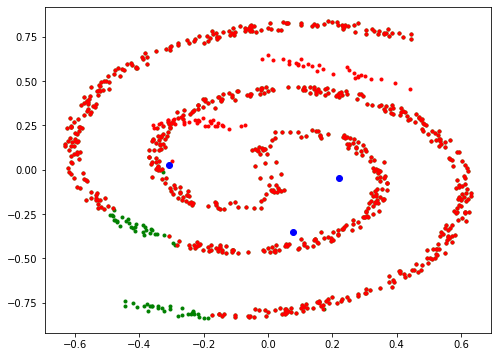

Step: 13000, error: 0.003444


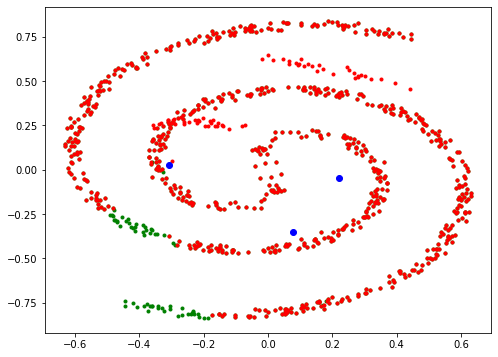

Step: 14000, error: 0.003444


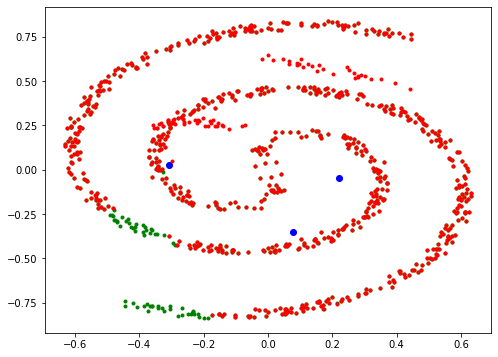

In [149]:
EPOCHS = 15000
for i in range(EPOCHS):
    yout = net[0](XX)
    error = criterion(dists, yout)
#     error = ((dists-yout).abs()).mean()

#     error += seq_criterion(yout, dists, int(i/EPOCHS*net[0].num_centers + 1))
#     error += ((dists-yout)**2).max(dim=1)[0].mean()
#     error += ((dists-yout)**2).max(dim=0)[0].mean()
    
    
    xoptim.zero_grad()
    error.backward(retain_graph=True)
    xoptim.step()
    if i%1000 == 0:
        print(f"Step: {i}, error: {error:.6f}")
        
        fig = plt.figure(figsize=(8,6))
        plt.scatter(xx[:,0].cpu(), xx[:,1].cpu(), c='g', marker='.')
        plt.scatter(XX.data[:,0].cpu(), XX.data[:,1].cpu(), c='r', marker='.')
        plt.scatter(net[0].centers.data[:,0].cpu(), net[0].centers.data[:,1].cpu(), c='b', marker='o')
        
        plt.show()

In [51]:
# net[0]

AttributeError: 'DistanceTransformBase' object has no attribute 'inverse'